In [1]:
%pylab inline
import emcee
import programas as pg
import h5py
import MAS_library as MASL
import smoothing_library as SL

Populating the interactive namespace from numpy and matplotlib


## k = 0.75      1.133332583169743 0.547241485063514 -1.186469153048303
## k = 0.07:      0.9476487088670137 -0.3040041138321189 -40.960364726065194

## Primero suavizo los campos creados (densidad, tidal, laplacian, etc. )

In [ ]:
field = np.load('F4.npy')

In [ ]:
grid = 540
BoxSize = 1440
Filter = 'Top-Hat'
threads = 10

In [ ]:
R = 10
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
field_smoothed = SL.field_smoothing(field, W_k, threads)
#np.save('F4_smooth.npy',field_smoothed)

## Luego tengo que calcular los perfiles (perfiles_ico.f90)

# Ahora realizo el ajuste

In [58]:
path = '/home/arodriguez/BACCO/bias-voids/pruebas_fit/perfiles/'
f0_file = np.load(path+'F0_perfiles_rmin=20_k0.75.npy')
f1_file = np.load(path+'F1_perfiles_rmin=20_k0.75.npy')
f2_file = np.load(path+'F2_perfiles_rmin=20_k0.75.npy')
f4_file = np.load(path+'F4_perfiles_rmin=20_k0.75.npy')

f0 = f0_file[:,1:]
f1 = f1_file[:,1:]
f2 = f2_file[:,1:]
f4 = f4_file[:,1:]

realizaciones = 80

mean_0, error_0 = pg.perfil_jack(f0,realizaciones)
mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
mean_4, error_4 = pg.perfil_jack(f4,realizaciones)

original = np.load(path+'perfiles_simu_rmin=20_k0.75.npy')
obs = original[:,1:]
mean_obs, error_obs = pg.perfil_jack(obs,realizaciones)

In [3]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F0, F1, F2, F4, C_inv):
    b1, b2, b4 = params
    model = F0 + b1 * F1 + b2 * F2 + b4*F4 - 1
    diff = F_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b4 = params
    if -20 < b1 < 20 and -20 < b2 < 20 and -50 < b4 < 50:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F0, F1, F2, F4, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F0, F1, F2, F4, C_inv)

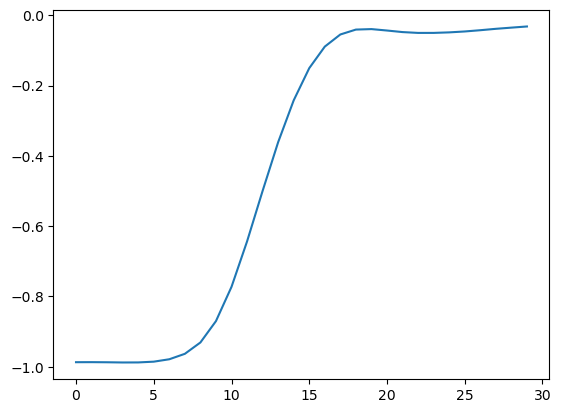

In [6]:
plt.plot(mean_obs)

In [7]:
def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [59]:
# IMPORTANTE: numero de jacknife tiene que ser mayor que el numero de bines (sino no puede invertirse)
realizaciones = 80
mean_obs, error_obs, all_obs = perfil_jack(obs,realizaciones)

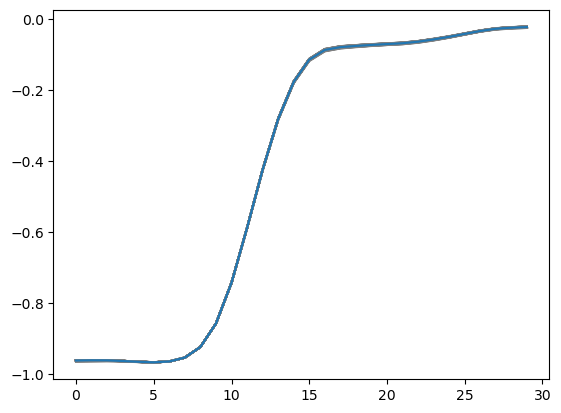

In [60]:
for i in range(all_obs.shape[0]):
    plt.plot(all_obs[i,:],color='grey')
plt.plot(mean_obs)

## Covariance Matrix
$ C_{ij} = \frac{n-1}{n}·\sum_{k=1}^n (\xi_k-\hat{\xi})_i·(\xi_k - \hat{\xi})_j $

que se normaliza como:

$ C_{ij}/\sqrt(C_{ii}C_{jj}) $

In [61]:
def covariance_mat(pmean, pall):
    
    njack  = pall.shape[0]
    nbines = pall.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

In [62]:
C = covariance_mat(mean_obs,all_obs)

# normalization:
ies = C.shape[0]
jes = C.shape[1]

C_new = np.zeros([ies,jes])

for i in range(ies):
    for j in range(jes):
        
        C_new[i,j] = C[i,j]/np.sqrt(C[i,i]*C[j,j])
        
C = C_new

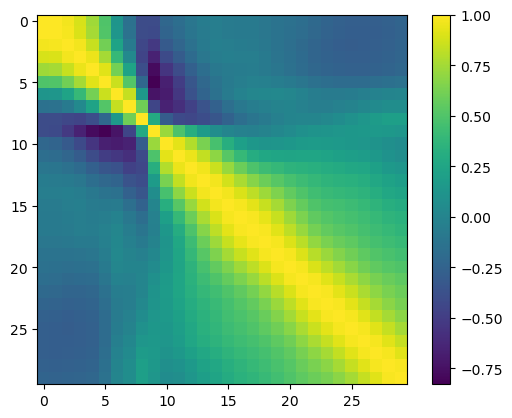

In [63]:
plt.imshow(C)
plt.colorbar()

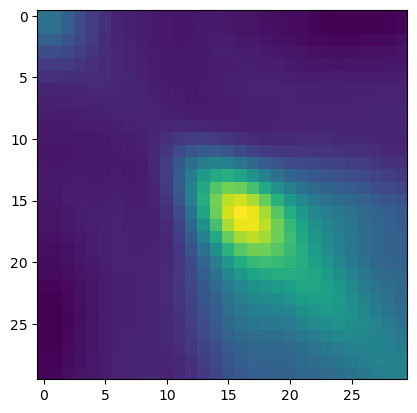

In [64]:
C = covariance_mat(mean_obs,all_obs)
plt.imshow(C)

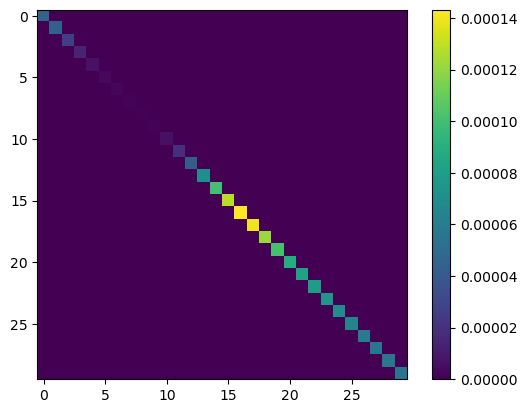

In [65]:
C = covariance_mat(mean_obs,all_obs)
C_diag = np.diag(np.diag(C))
plt.imshow(C_diag)
plt.colorbar()

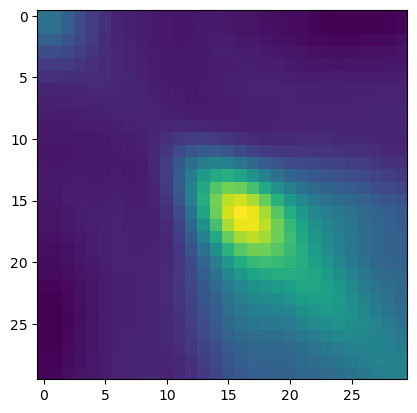

In [66]:
num_bines = mean_obs.shape[0]
C_identity = np.identity(num_bines)
plt.imshow(C)

In [67]:
njack = realizaciones
factor_h = 1 - (num_bines+1)/(njack-1)

In [68]:
print(njack, factor_h)

80 0.6075949367088608


In [69]:
F_obs = mean_obs
F0 = mean_0
F1 = mean_1
F2 = mean_2
F4 = mean_4


# Inverso de la matriz de covarianza
C_inv = factor_h*np.linalg.inv(C)
C_inv = np.linalg.inv(C)

# Configuración de MCMC
ndim = 3  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 10000  # Número de pasos

# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F0, F1, F2, F4, C_inv))
_ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 302.53it/s]


In [70]:
# Análisis de resultados
samples = sampler.get_chain(discard=500, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b4_samples = samples[:, 0], samples[:, 1], samples[:,2]

In [71]:
len(b1_samples)

47500

In [72]:
import random


seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)

b1 = 1.3148259428137512 ± 0.007254104277471237
b2 = 0.5298927905727965 ± 0.027166783257563415
b4 = 4.848347425318719 ± 0.12514040610721228


Text(0, 0.5, '$\\theta_4$')

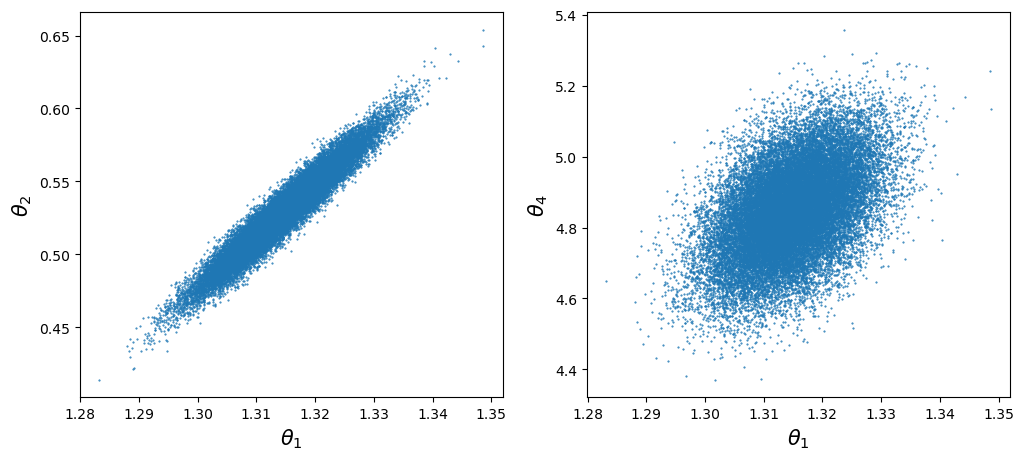

In [73]:
# Calcular medias y desviaciones estándar
b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

print(f"b1 = {b1_mean} ± {b1_std}")
print(f"b2 = {b2_mean} ± {b2_std}")
print(f"b4 = {b4_mean} ± {b4_std}")


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(b1_samples[seleccion],b2_samples[seleccion],ls='none',marker='o',markersize=.5)
plt.xlabel('$\\theta_1$',size=15)
plt.ylabel('$\\theta_2$',size=15)

plt.subplot(122)
plt.plot(b1_samples[seleccion],b4_samples[seleccion],ls='none',marker='o',markersize=.5)
plt.xlabel('$\\theta_1$',size=15)
plt.ylabel('$\\theta_4$',size=15)

In [74]:
#b1_jens = 1.13
#b2_jens = 0.55
#b4_jens = -1.19

b1_jens = 1.04
b2_jens = 0.24
b4_jens = -2.45

In [75]:
dist = np.linspace(0,3,30)

Text(0, 0.5, '$ \\delta_g(r) $')

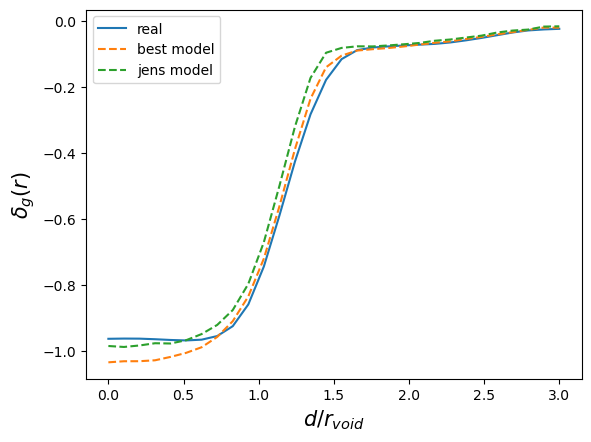

In [76]:
plt.plot(dist, F_obs, label='real')
plt.plot(dist, F0 + b1_mean*F1 + b2_mean*F2 + b4_mean*F4 - 1, ls='dashed', label='best model')
plt.plot(dist, F0 + b1_jens*F1 + b2_jens*F2 + b4_jens*F4 - 1, ls='dashed', label='jens model')

#plt.plot(F1,label='F1')
#plt.plot(F2,label='F2')
plt.legend()
#plt.ylim(-1.4,0.2)
plt.xlabel('$ d/r_{void}$',size=15)
plt.ylabel('$ \\delta_g(r) $',size=15)

## Grafico estilo cosmo

In [77]:
from scipy.stats import gaussian_kde

# Crear un objeto de KDE
kde = gaussian_kde([b1_samples[seleccion], b2_samples[seleccion]])

# Crear una malla de puntos donde evaluar KDE
x = np.linspace(min(b1_samples), max(b1_samples), 100)
y = np.linspace(min(b2_samples), max(b2_samples), 100)
X, Y = np.meshgrid(x, y)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

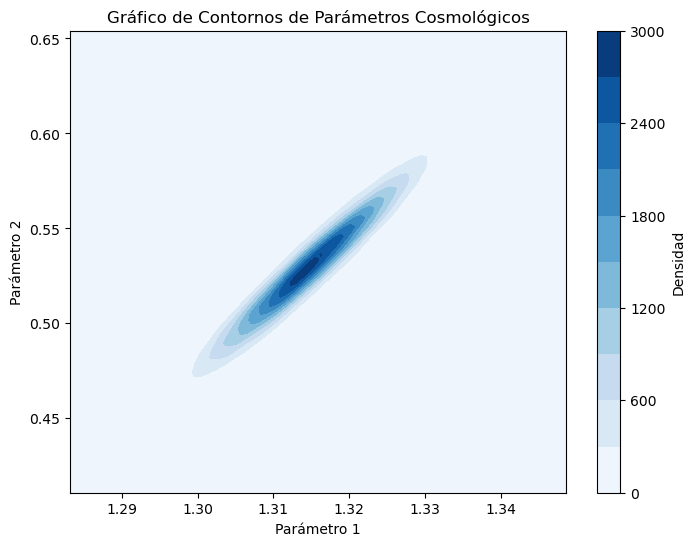

In [78]:
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=10, cmap='Blues')  # Contornos con 10 niveles
plt.xlabel('Parámetro 1')
plt.ylabel('Parámetro 2')
plt.title('Gráfico de Contornos de Parámetros Cosmológicos')
plt.colorbar(label='Densidad')
plt.show()

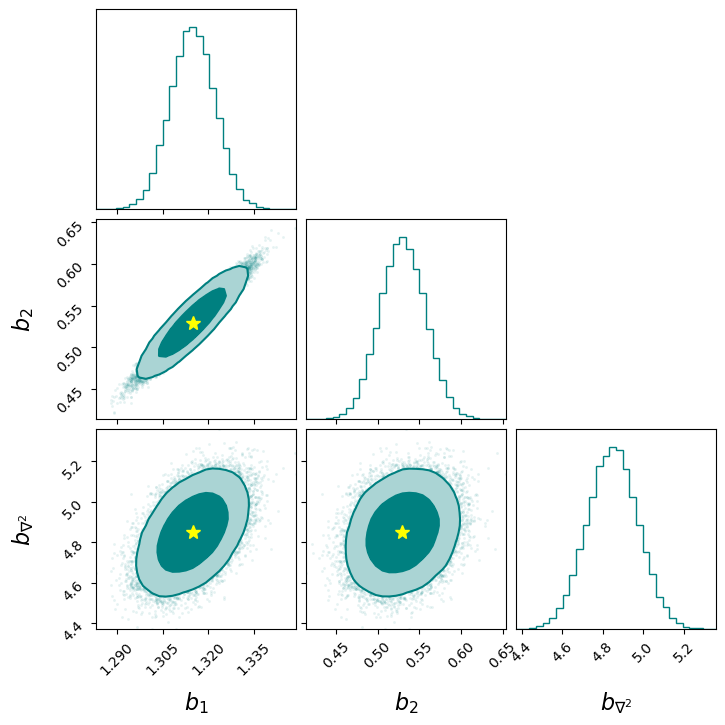

In [79]:
import corner

# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples[seleccion], b2_samples[seleccion], b4_samples[seleccion]]).T,
                       labels=["$ b_1 $", "$b_2$", "$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
axes[3].plot(b1_jens, b2_jens, marker='*', color='red', markersize=10)
axes[3].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
axes[6].plot(b1_jens, b4_jens, marker='*', color='red', markersize=10)
axes[6].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b2, b4)
axes[7].plot(b2_jens, b4_jens, marker='*', color='red', markersize=10)
axes[7].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)

In [80]:
print('BACCO:',b1_jens, b2_jens, b4_jens)
print('BACCO:',b1_mean, b2_mean, b4_mean)

BACCO: 1.04 0.24 -2.45
BACCO: 1.3148259428137512 0.5298927905727965 4.848347425318719


# **Perfiles**

In [81]:
modelo = f0 + b1_mean*f1 + b2_mean*f2 + b4_mean*f4 - 1
modelo_jens = f0 + b1_jens*f1 + b2_jens*f2 + b4_jens*f4 - 1

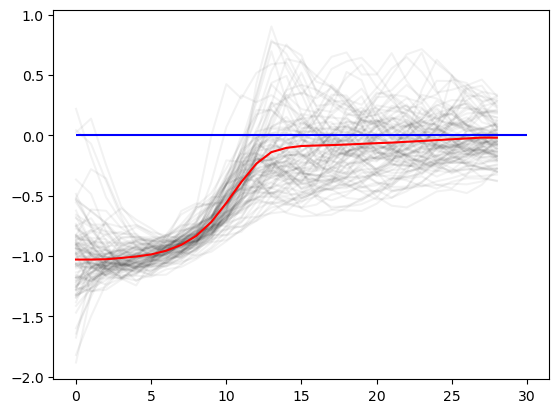

In [82]:
## Los perfiles de mi modelo quedan
delta = modelo
realizaciones = 20
mean, error = pg.perfil_jack(delta[:,1:],realizaciones)

for i in range(100):
    plt.plot(delta[i,1:],color='black',alpha=.05)
    
plt.plot(np.mean(delta[:,1:],axis=0),color='red')
#plt.plot(mean,color='yellow')
plt.hlines(y=0,xmin=0,xmax=30,color='blue')

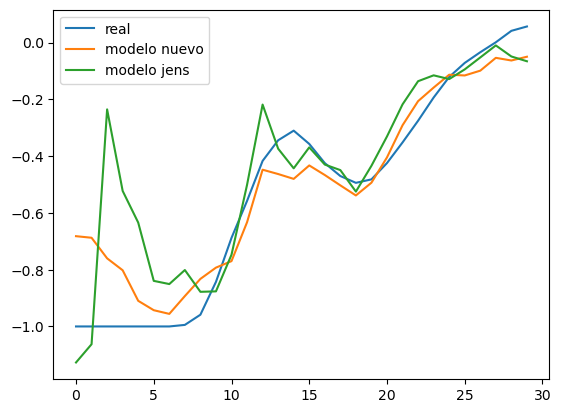

In [83]:
## comparacion de perfiles individuales

nid = 20
plt.plot(obs[nid,:], label='real')
plt.plot(modelo[nid,:], label='modelo nuevo')
plt.plot(modelo_jens[nid,:], label='modelo jens')
plt.legend()

In [84]:
dif_model, dif_model_e = pg.perfil_jack(modelo[:,1:]-obs[:,1:],realizaciones)
dif_modelj, dif_modelj_e = pg.perfil_jack(modelo_jens[:,1:]-obs[:,1:],realizaciones)

In [85]:
modelo.shape

(607, 30)

Text(0.5, 0, '$ d/r_{void}$')

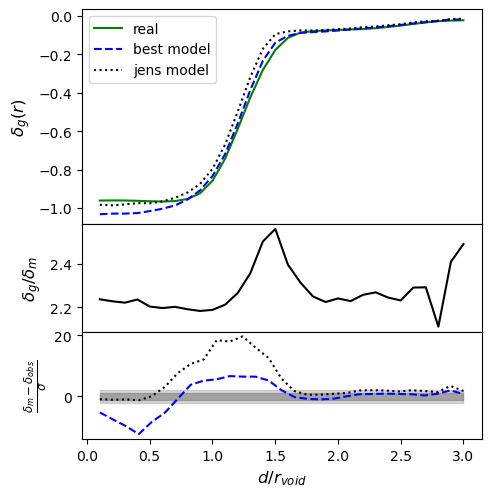

In [86]:
fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(5,5),sharey='row'
                       ,gridspec_kw={'height_ratios': [2, 1, 1]})
fig.subplots_adjust(hspace=(0.00),wspace=(.28),bottom=0.12, top=0.98, left=0.17, right=0.97)

F_model_j = F0 + b1_jens*F1 + b2_jens*F2 + b4_jens*F4 - 1
F_model_m = F0 + b1_mean*F1 + b2_mean*F2 + b4_mean*F4 - 1

ax[0].plot(dist, F_obs, label='real', color='green')
ax[0].plot(dist, F_model_m, ls='dashed', label='best model', color='blue')
ax[0].plot(dist, F_model_j, ls='dotted', label='jens model', color='black')
ax[0].legend()
#plt.ylim(-1.4,0.2)

ax[0].set_ylabel('$ \\delta_g(r) $',size=12)

ax[1].plot(dist, F_model_m/F1, color='black')
ax[1].set_ylabel('$ \\delta_g/\\delta_m $',size=12)
#ax[1].set_ylim(1.5,3.5)

ax[2].plot(dist[1:],dif_model/dif_model_e, color='blue',ls='dashed')
ax[2].plot(dist[1:],dif_modelj/dif_modelj_e, color='black',ls='dotted')

ax[2].fill_between(dist[1:],1,-1,color='grey',alpha=.6)
ax[2].fill_between(dist[1:],2,-2,color='grey',alpha=.3)
#ax[2].set_ylim(-16,16)
ax[2].set_ylabel('$\\frac{\\delta_m-\\delta_{obs}}{\\sigma}$',size=12)
#ax[2].set_ylim(-8,8)
ax[2].set_xlabel('$ d/r_{void}$',size=12)

# **DISCUTIR**

### Dado que el fiteo anda bien a partir de los 2 r_void, capaz es mejor excluir esa region y concentrarse en fitear la region interna?